In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import VotingRegressor
from sklearn.decomposition import PCA

def evaluate_model(model, X_test, y_test, model_name="Model"):
    y_pred = model.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"\n{model_name} Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")

    return y_pred

def plot_predictions(y_true, y_pred, weights=None, title="Model Predictions"):
    plt.figure(figsize=(10, 8))

    if weights is not None:
        scatter = plt.scatter(y_true, y_pred, c=weights, cmap='viridis',
                            alpha=0.6, label='Predictions')
        plt.colorbar(scatter, label='Weight')
    else:
        plt.scatter(y_true, y_pred, alpha=0.6, label='Predictions')

    plt.plot([0, 1], [0, 1], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(title)

    # Add metrics to plot
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    plt.text(0.05, 0.95, f'R² = {r2:.3f}\nRMSE = {rmse:.3f}\nMAE = {mae:.3f}',
             transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.8))

    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_feature_importances(model, feature_names, title="Feature Importances"):
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(importances)), importances[indices])
    plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print(f"\n{title}:")
    for idx in indices:
        print(f"{feature_names[idx]}: {importances[idx]:.4f}")

"""
def plot_feature_importances(model, feature_names, title="Feature Importances"):
    print("DELETE THIS FUNCTION IF YOU WANT FEATURE IMPORTANCES")
"""

filepath = '../data/E-INSPIRE_I_master_catalogue.csv'
random_state = 2



Base Model Evaluation:

Base Model Metrics:
R² Score: 0.8003
RMSE: 0.0695
MAE: 0.0501


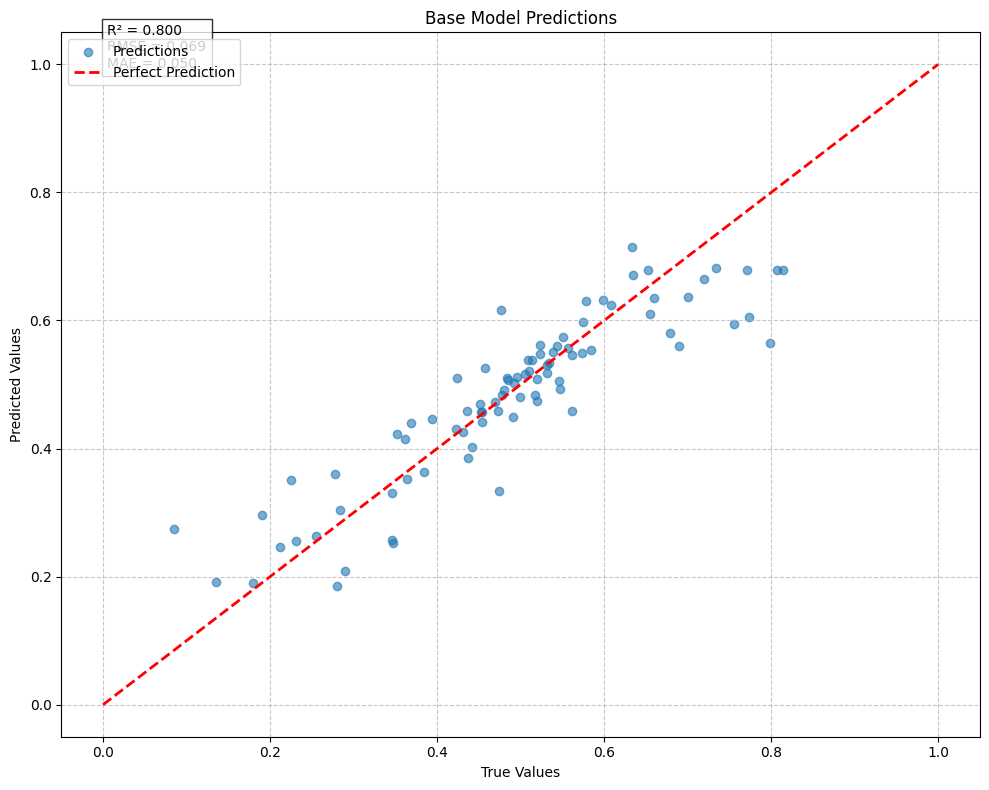

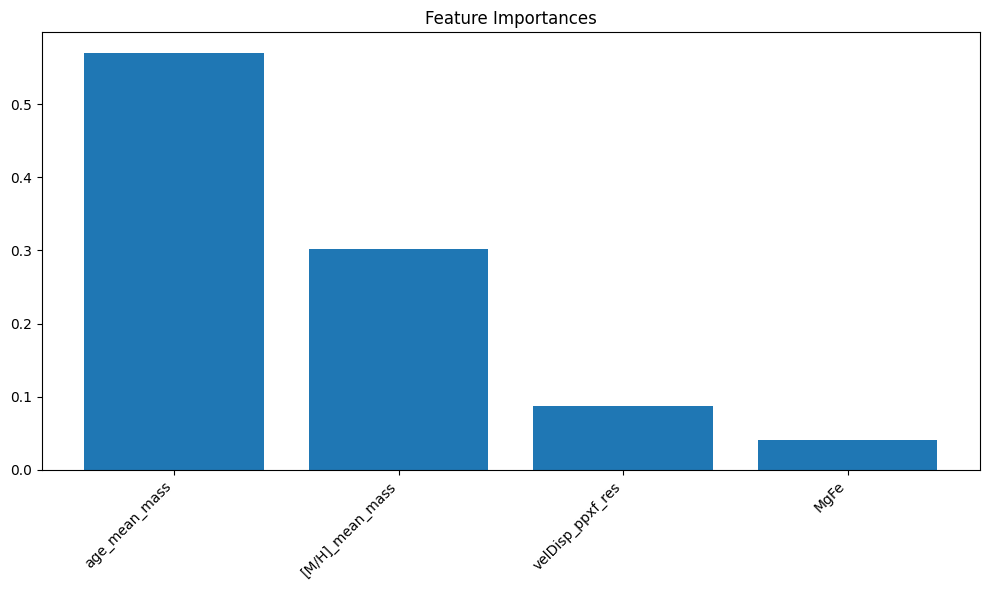


Feature Importances:
age_mean_mass: 0.5696
[M/H]_mean_mass: 0.3019
velDisp_ppxf_res: 0.0878
MgFe: 0.0407


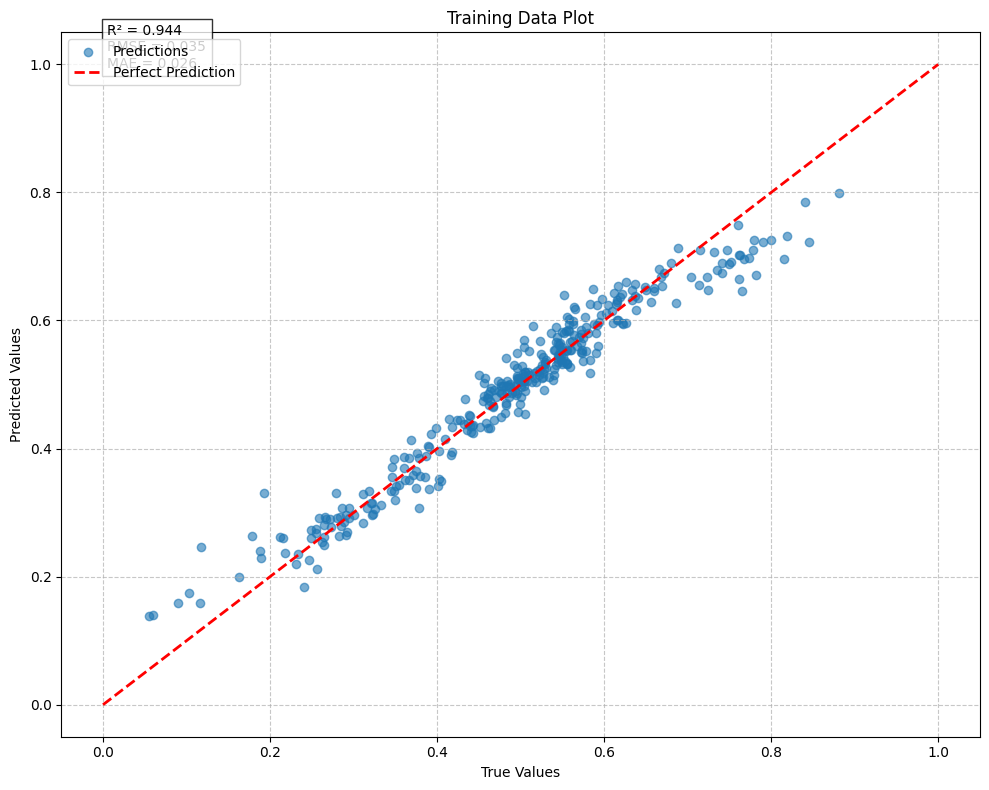

(RandomForestRegressor(max_depth=20, max_features=0.7, min_samples_split=5,
                       n_estimators=500, random_state=2),
 StandardScaler())

In [2]:
def run_base_model(filepath):
    df = pd.read_csv(filepath)
    standard_features = ['MgFe', '[M/H]_mean_mass', 'velDisp_ppxf_res', 'age_mean_mass']
    X = df[standard_features]
    y = df['DoR']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    base_model = RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_split=5,
        max_features=0.7,
        random_state=random_state
    )
    
    base_model.fit(X_train_scaled, y_train)
    
    print("\nBase Model Evaluation:")
    y_pred = evaluate_model(base_model, X_test_scaled, y_test, "Base Model")
    plot_predictions(y_test, y_pred, title="Base Model Predictions")
    plot_feature_importances(base_model, standard_features)
    
    plot_predictions(y_train, base_model.predict(X_train_scaled), title="Training Data Plot")

    return base_model, scaler

run_base_model(filepath)


Model with Error Features Evaluation:

Error Features Model Metrics:
R² Score: 0.8362
RMSE: 0.0629
MAE: 0.0451


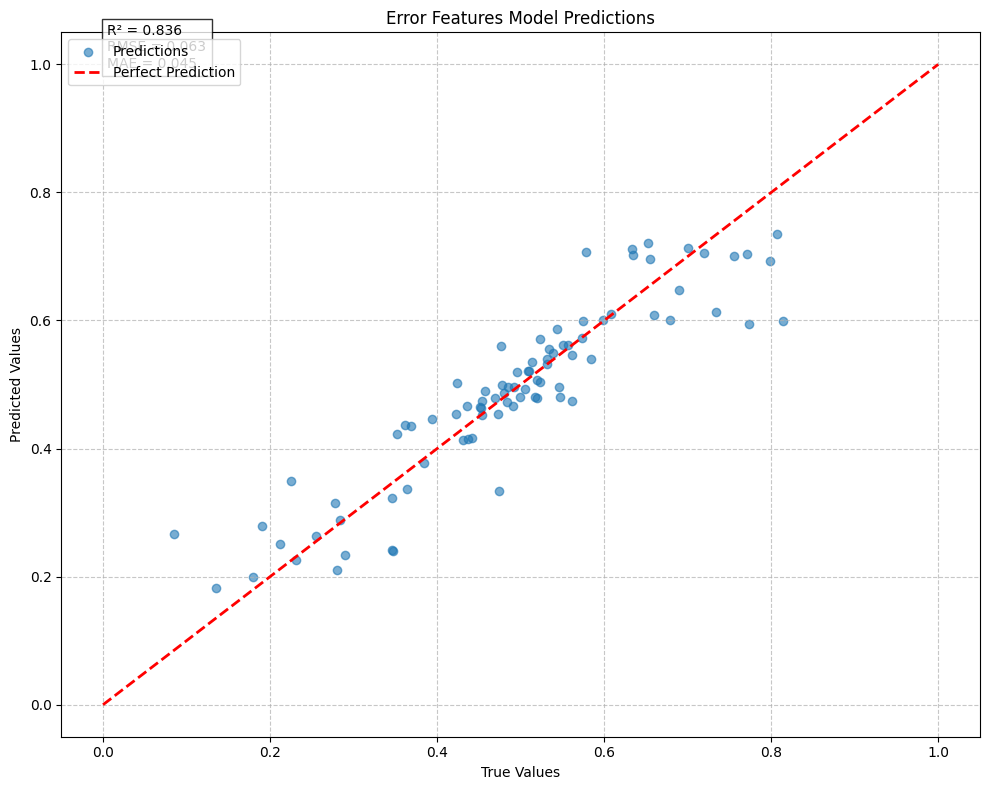

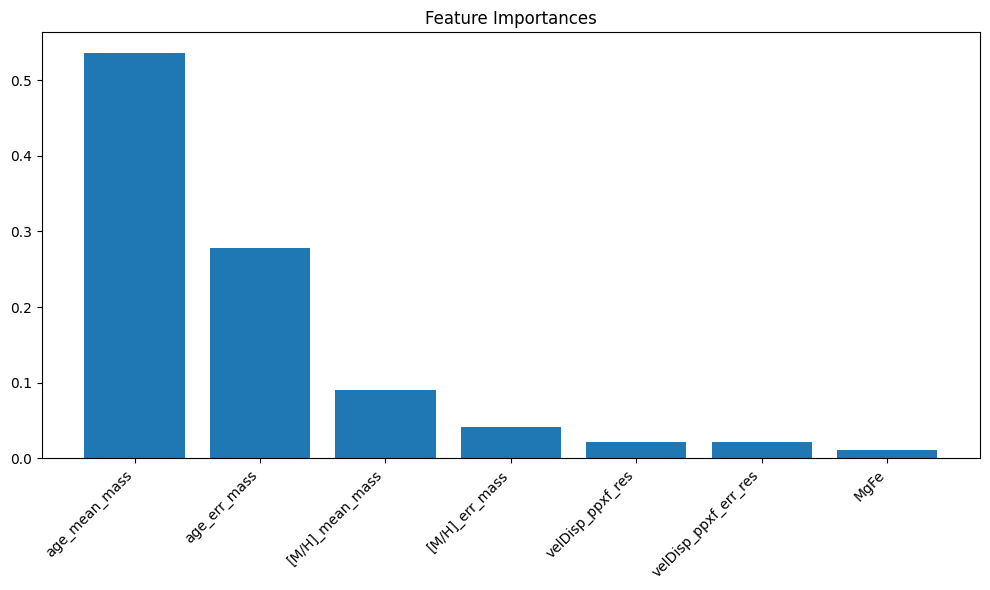


Feature Importances:
age_mean_mass: 0.5364
age_err_mass: 0.2776
[M/H]_mean_mass: 0.0900
[M/H]_err_mass: 0.0415
velDisp_ppxf_res: 0.0220
velDisp_ppxf_err_res: 0.0218
MgFe: 0.0107


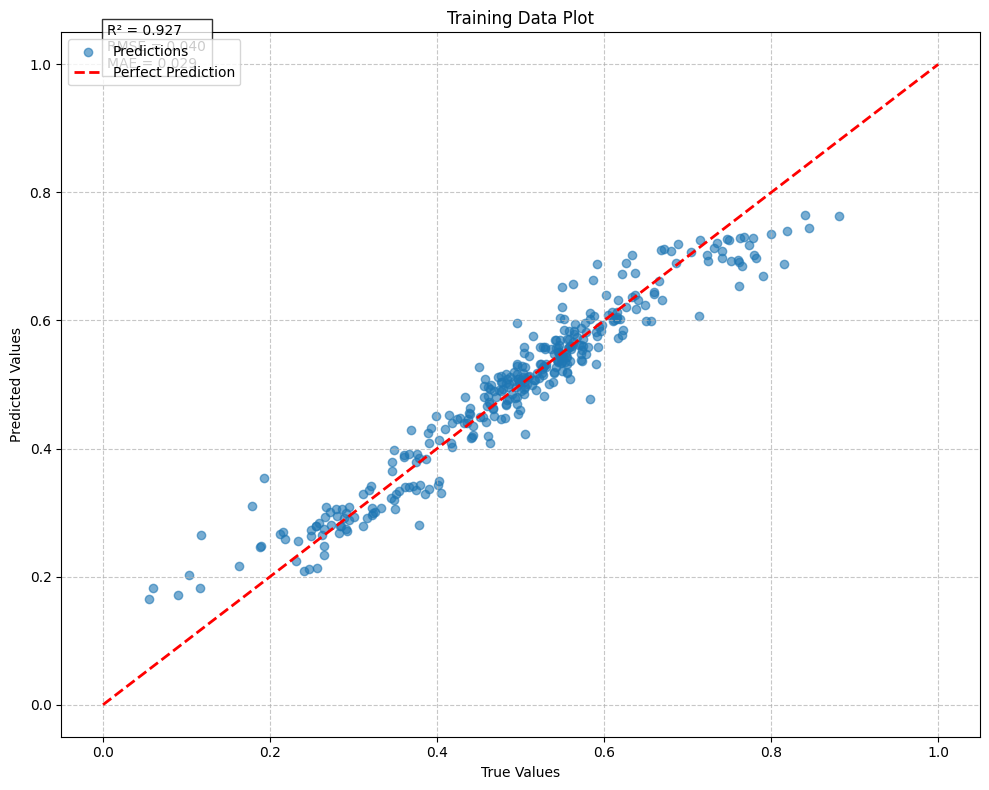

(RandomForestRegressor(max_depth=22, max_features=0.793, max_samples=0.5,
                       min_samples_split=4, n_estimators=460, random_state=42),
 StandardScaler())

In [3]:
def run_error_feature_model(filepath):
    # Load data
    df = pd.read_csv(filepath)
    features_with_errors = [
        'MgFe',
        '[M/H]_mean_mass', '[M/H]_err_mass',
        'velDisp_ppxf_res', 'velDisp_ppxf_err_res',
        'age_mean_mass', 'age_err_mass'
    ]
    X = df[features_with_errors]
    y = df['DoR']
    
    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    error_model = RandomForestRegressor(
        max_depth=22,       
        max_features=0.793,         
        max_samples=0.500,            
        min_samples_leaf=1,             
        min_samples_split=4,           
        n_estimators=460,                
        random_state=42                  
    )
    error_model.fit(X_train_scaled, y_train)
    
    # Evaluate and plot
    print("\nModel with Error Features Evaluation:")
    y_pred = evaluate_model(error_model, X_test_scaled, y_test, "Error Features Model")
    plot_predictions(y_test, y_pred, title="Error Features Model Predictions")
    plot_feature_importances(error_model, features_with_errors)
    
    plot_predictions(y_train, error_model.predict(X_train_scaled), title="Training Data Plot")
    
    return error_model, scaler

run_error_feature_model(filepath)


Weighted Points Model Evaluation:

Weighted Points Model Metrics:
R² Score: 0.8101
RMSE: 0.0678
MAE: 0.0495


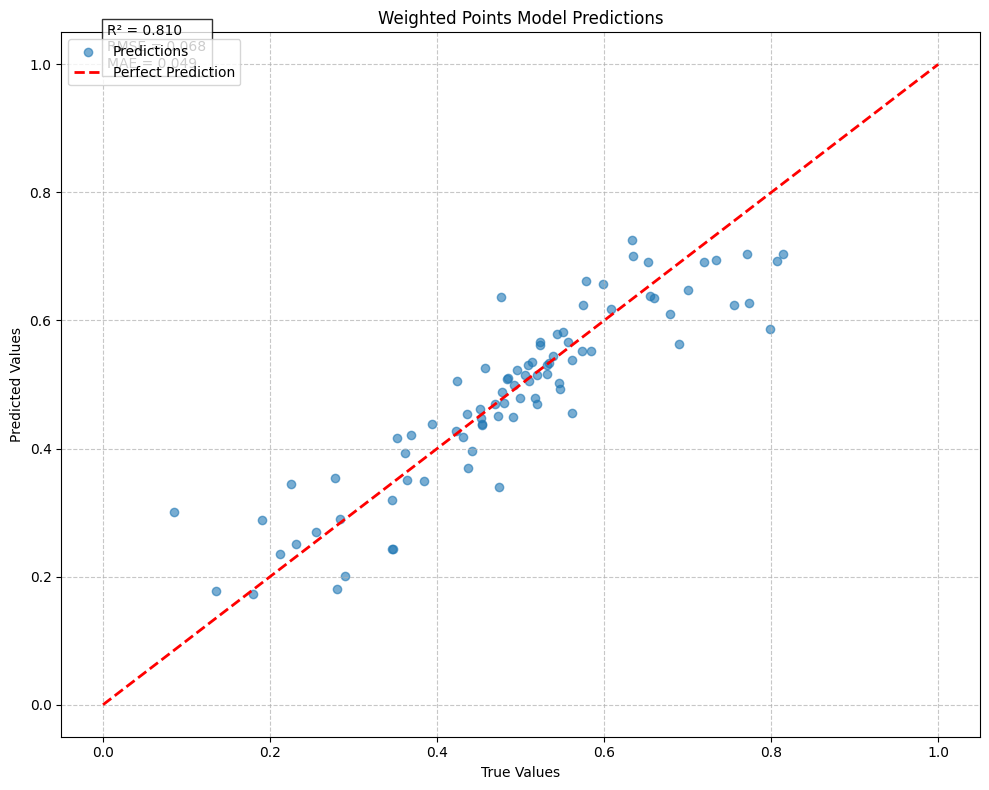

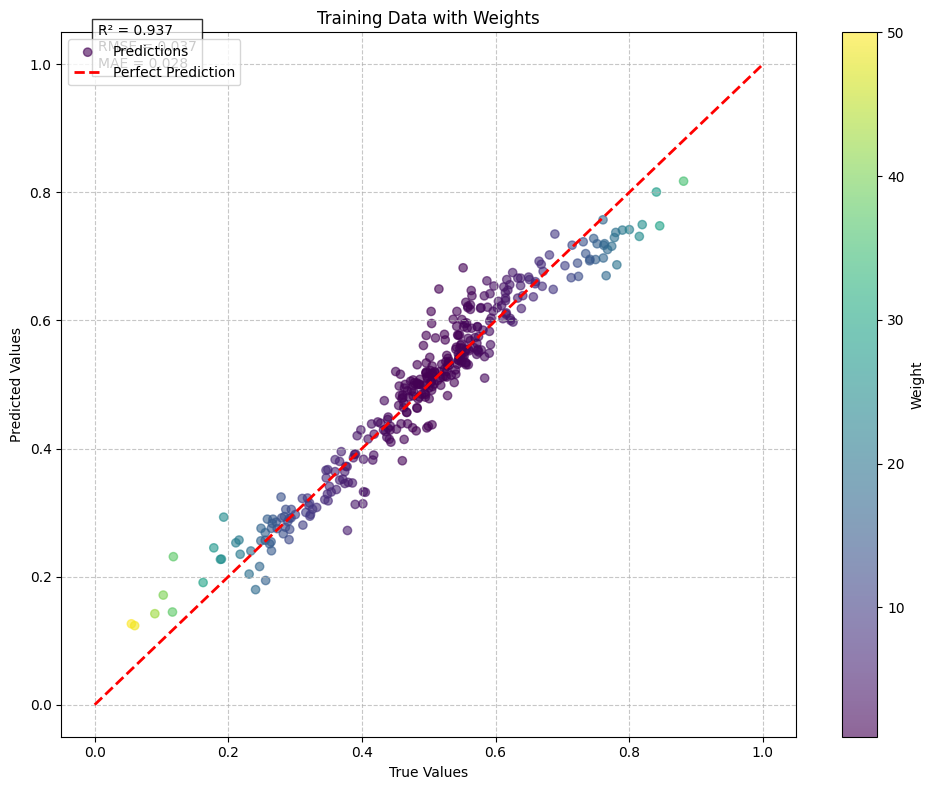

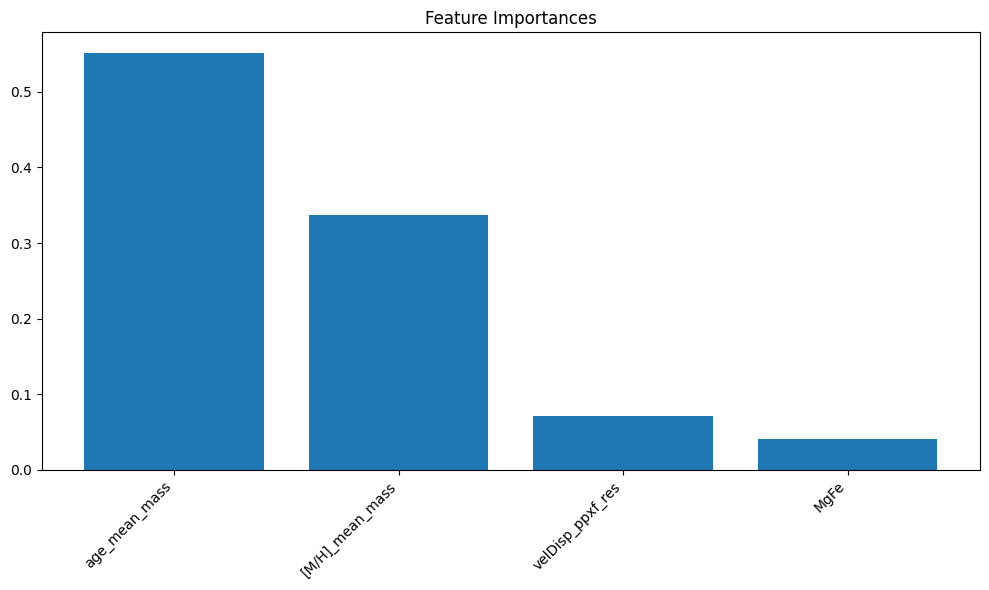


Feature Importances:
age_mean_mass: 0.5512
[M/H]_mean_mass: 0.3374
velDisp_ppxf_res: 0.0711
MgFe: 0.0403


(RandomForestRegressor(max_depth=20, max_features=0.7, min_samples_split=5,
                       n_estimators=500, random_state=2),
 StandardScaler(),
 68      1.009190
 356     6.494626
 114    12.666223
 216     1.634387
 40      1.746037
          ...    
 299    17.104768
 22      2.972218
 72      1.944662
 15      4.008968
 168     3.634839
 Name: DoR, Length: 344, dtype: float64)

In [4]:
def run_weighted_points_model(filepath, max_weight = 10, power =2):
    # Load data
    df = pd.read_csv(filepath)
    standard_features = ['MgFe', '[M/H]_mean_mass', 'velDisp_ppxf_res', 'age_mean_mass']
    X = df[standard_features]
    y = df['DoR']
    
    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Calculate weights
    mean_y = np.median(y_train)
    distances = np.abs(y_train - mean_y)
    weights = 1 + (distances / np.max(distances))**power * (max_weight - 1)
    
    # Train weighted model
    weighted_model = RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_split=5,
        max_features=0.7,
        random_state=random_state
    )
    weighted_model.fit(X_train_scaled, y_train, sample_weight=weights)
    
    # Evaluate and plot
    print("\nWeighted Points Model Evaluation:")
    y_pred = evaluate_model(weighted_model, X_test_scaled, y_test, "Weighted Points Model")
    plot_predictions(y_test, y_pred, title="Weighted Points Model Predictions")
    plot_predictions(y_train, weighted_model.predict(X_train_scaled), 
                    weights=weights, title="Training Data with Weights")
    
    plot_feature_importances(weighted_model, standard_features)
    
    return weighted_model, scaler, weights

run_weighted_points_model(filepath, max_weight = 50, power =2)


Polynomial Features Model Evaluation:

Polynomial Features Model Metrics:
R² Score: 0.8056
RMSE: 0.0686
MAE: 0.0498


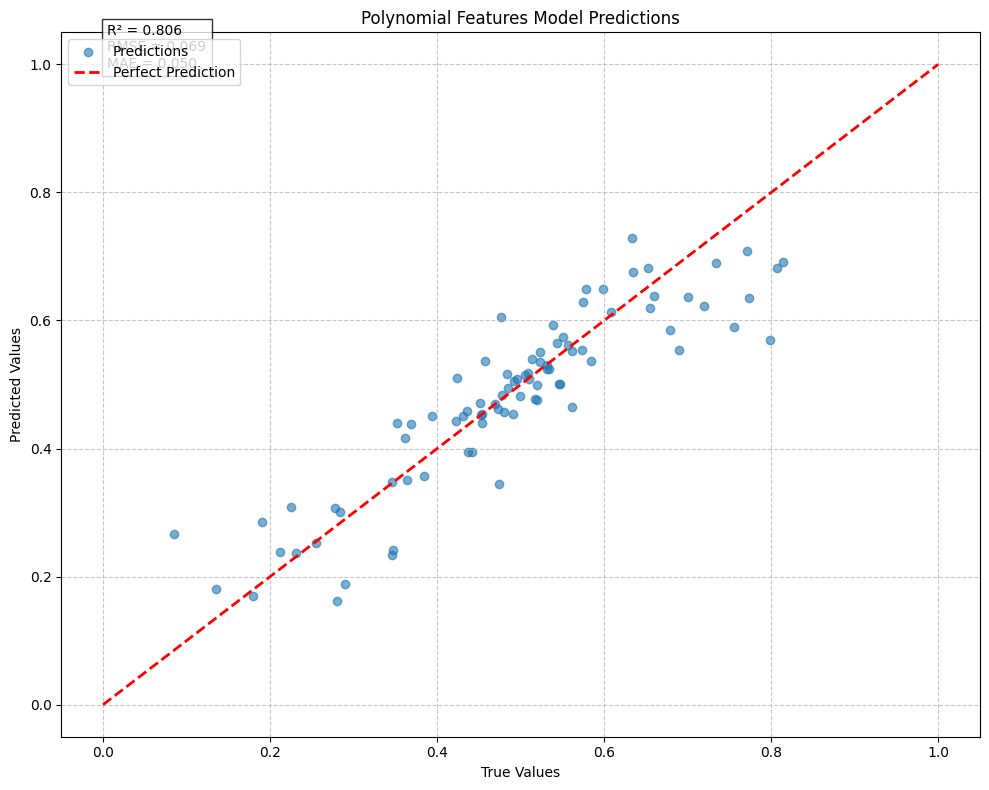

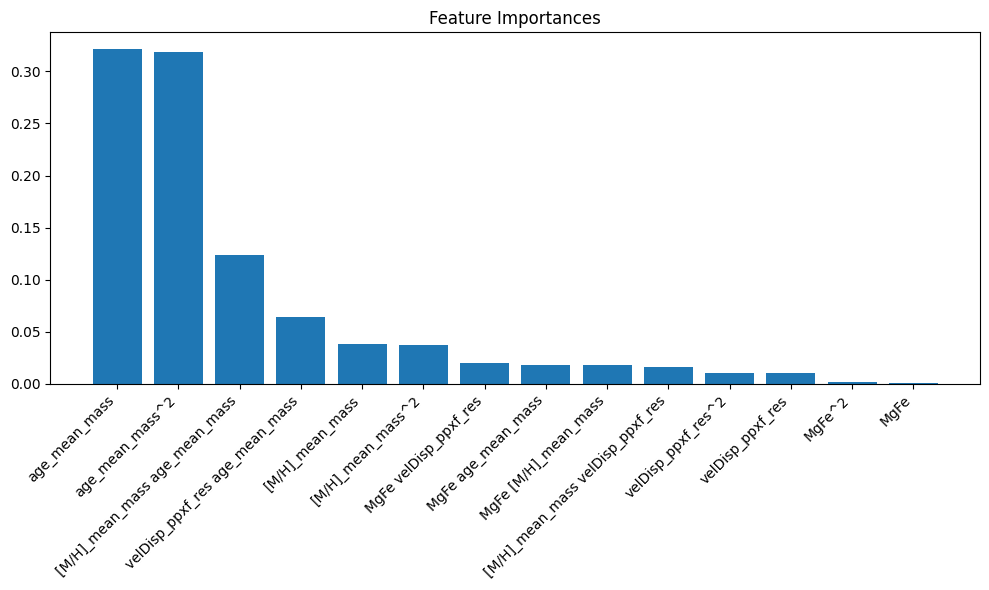


Feature Importances:
age_mean_mass: 0.3215
age_mean_mass^2: 0.3185
[M/H]_mean_mass age_mean_mass: 0.1240
velDisp_ppxf_res age_mean_mass: 0.0638
[M/H]_mean_mass: 0.0387
[M/H]_mean_mass^2: 0.0372
MgFe velDisp_ppxf_res: 0.0196
MgFe age_mean_mass: 0.0182
MgFe [M/H]_mean_mass: 0.0179
[M/H]_mean_mass velDisp_ppxf_res: 0.0163
velDisp_ppxf_res^2: 0.0109
velDisp_ppxf_res: 0.0107
MgFe^2: 0.0015
MgFe: 0.0012


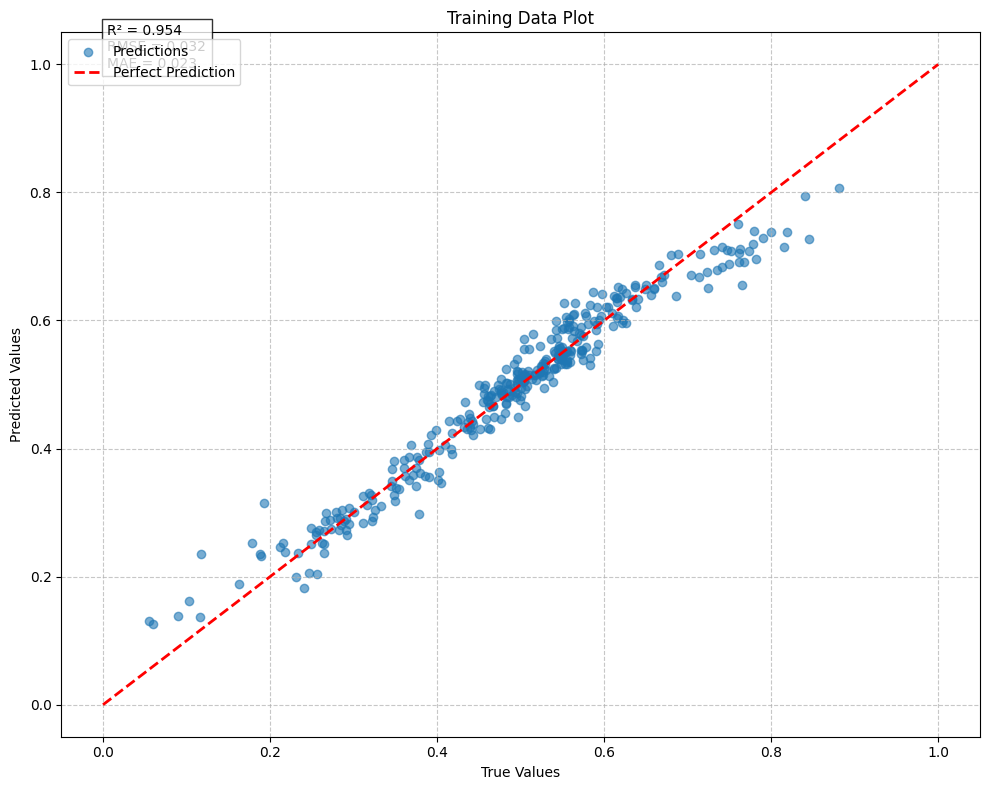

Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('scaler', StandardScaler()),
                ('rf',
                 RandomForestRegressor(max_depth=20, max_features=0.7,
                                       min_samples_split=5, n_estimators=500,
                                       random_state=2))])

In [5]:
def run_polynomial_model(filepath):
    # Load data
    df = pd.read_csv(filepath)
    standard_features = ['MgFe', '[M/H]_mean_mass', 'velDisp_ppxf_res', 'age_mean_mass']
    X = df[standard_features]
    y = df['DoR']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    
    # Trying pipeline instead..
    poly_model = Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(
            n_estimators=500,
            max_depth=20,
            min_samples_split=5,
            max_features=0.7,
            random_state=random_state
        ))
    ])
    
    poly_model.fit(X_train, y_train)
    
    # Evaluate and plot
    print("\nPolynomial Features Model Evaluation:")
    y_pred = evaluate_model(poly_model, X_test, y_test, "Polynomial Features Model")
    plot_predictions(y_test, y_pred, title="Polynomial Features Model Predictions")
    
    # Get feature names for polynomial features
    poly_features = poly_model.named_steps['poly'].get_feature_names_out(standard_features)
    plot_feature_importances(poly_model.named_steps['rf'], poly_features)
    
    plot_predictions(y_train, poly_model.predict(X_train), title="Training Data Plot")

    return poly_model

run_polynomial_model(filepath)


Training Improved Neural Network Ensemble...

Improved Neural Network Ensemble Evaluation:

Neural Network Ensemble Metrics:
R² Score: 0.8043
RMSE: 0.0688
MAE: 0.0495


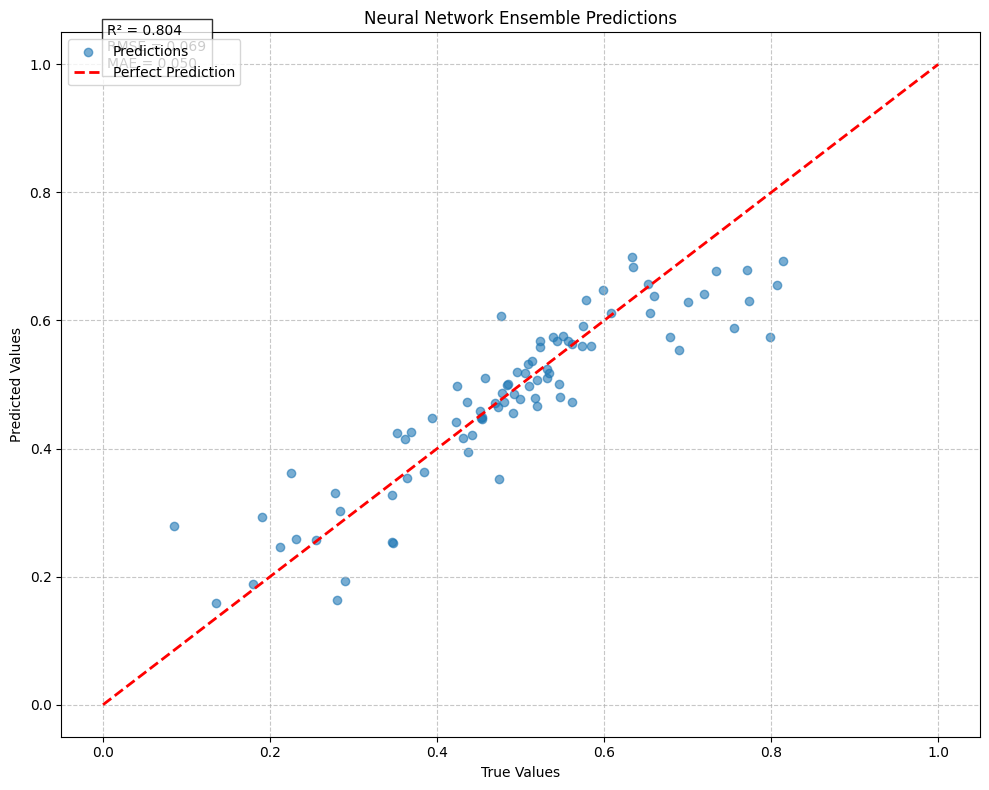

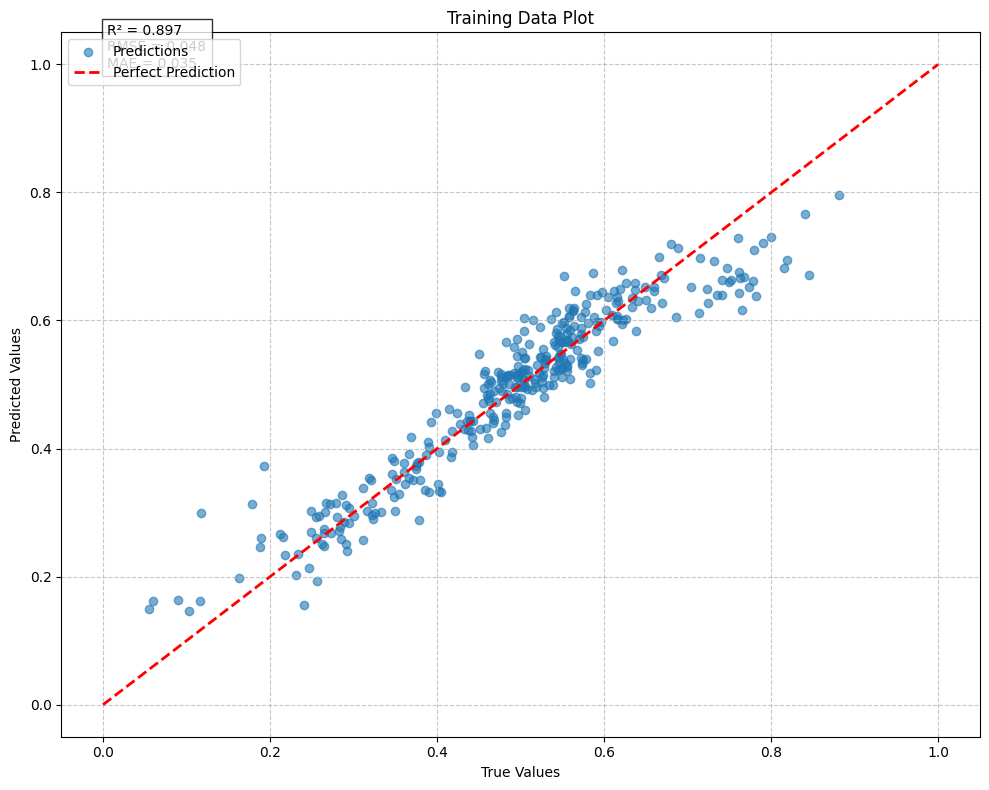

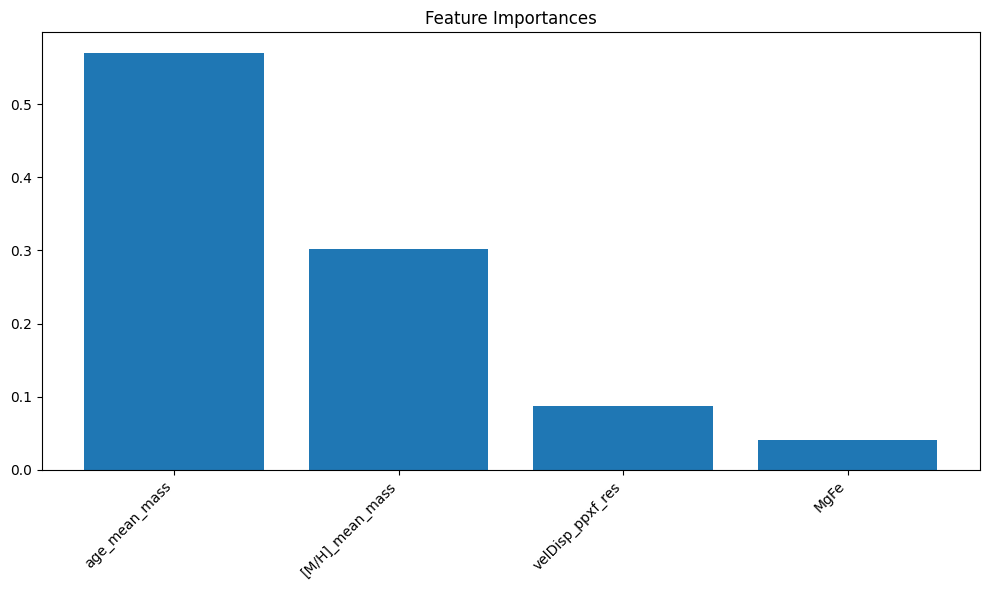


Feature Importances:
age_mean_mass: 0.5696
[M/H]_mean_mass: 0.3019
velDisp_ppxf_res: 0.0878
MgFe: 0.0407

Individual Model Performances:

Random Forest alone:

Random Forest Metrics:
R² Score: 0.8003
RMSE: 0.0695
MAE: 0.0501

Neural Network alone:

Neural Network Metrics:
R² Score: 0.7962
RMSE: 0.0702
MAE: 0.0514


(VotingRegressor(estimators=[('rf',
                              RandomForestRegressor(max_depth=20,
                                                    max_features=0.7,
                                                    min_samples_split=5,
                                                    n_estimators=500,
                                                    random_state=2)),
                             ('nn',
                              MLPRegressor(activation='tanh', alpha=0.01,
                                           hidden_layer_sizes=(64, 32),
                                           max_iter=2000, random_state=2,
                                           solver='lbfgs'))],
                 weights=[0.5, 0.5]),
 StandardScaler(),
 RandomForestRegressor(max_depth=20, max_features=0.7, min_samples_split=5,
                       n_estimators=500, random_state=2),
 MLPRegressor(activation='tanh', alpha=0.01, hidden_layer_sizes=(64, 32),
              max_iter=2000, ran

In [6]:
from sklearn.neural_network import MLPRegressor

def run_nn_ensemble_model(filepath):
    # Load data
    df = pd.read_csv(filepath)
    standard_features = ['MgFe', '[M/H]_mean_mass', 'velDisp_ppxf_res', 'age_mean_mass']
    X = df[standard_features]
    y = df['DoR']
    
    # Split and scale data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Create models
    rf = RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_split=5,
        max_features=0.7,
        random_state=random_state
    )
    
    nn = MLPRegressor(
        hidden_layer_sizes=(64, 32),  
        activation='tanh',            
        solver='lbfgs',              
        alpha=0.01,                  
        max_iter=2000,
        random_state=random_state
    )
    
    ensemble = VotingRegressor([
        ('rf', rf),
        ('nn', nn)
    ], weights=[0.5, 0.5])
    
    # Train models
    print("\nTraining Improved Neural Network Ensemble...")
    ensemble.fit(X_train_scaled, y_train)
    
    # Evaluate and plot
    print("\nImproved Neural Network Ensemble Evaluation:")
    y_pred = evaluate_model(ensemble, X_test_scaled, y_test, "Neural Network Ensemble")
    plot_predictions(y_test, y_pred, title="Neural Network Ensemble Predictions")
    
    # Plot training data predictions
    plot_predictions(y_train, ensemble.predict(X_train_scaled), 
                    title="Training Data Plot")
    
    plot_feature_importances(ensemble.named_estimators_['rf'], standard_features)
    
    
    # Individual models:
    print("\nIndividual Model Performances:")
    print("\nRandom Forest alone:")
    rf.fit(X_train_scaled, y_train)
    rf_pred = rf.predict(X_test_scaled)
    evaluate_model(rf, X_test_scaled, y_test, "Random Forest")
    
    print("\nNeural Network alone:")
    nn.fit(X_train_scaled, y_train)

    nn_pred = nn.predict(X_test_scaled)
    evaluate_model(nn, X_test_scaled, y_test, "Neural Network")
    
    return ensemble, scaler, rf, nn

run_nn_ensemble_model(filepath)


PCA Explained Variance Ratio:
PC1: 0.442 (44.2%)
PC2: 0.243 (24.3%)
PC3: 0.223 (22.3%)
Cumulative: 90.8%

PCA Component Loadings:
                       PC1       PC2       PC3
MgFe              0.308152  0.887989  0.202651
[M/H]_mean_mass   0.594252 -0.313240 -0.387116
velDisp_ppxf_res  0.340103 -0.334337  0.877410
age_mean_mass     0.660483  0.039693 -0.198056

PCA Random Forest Model Evaluation:

PCA Random Forest Metrics:
R² Score: 0.7643
RMSE: 0.0755
MAE: 0.0567


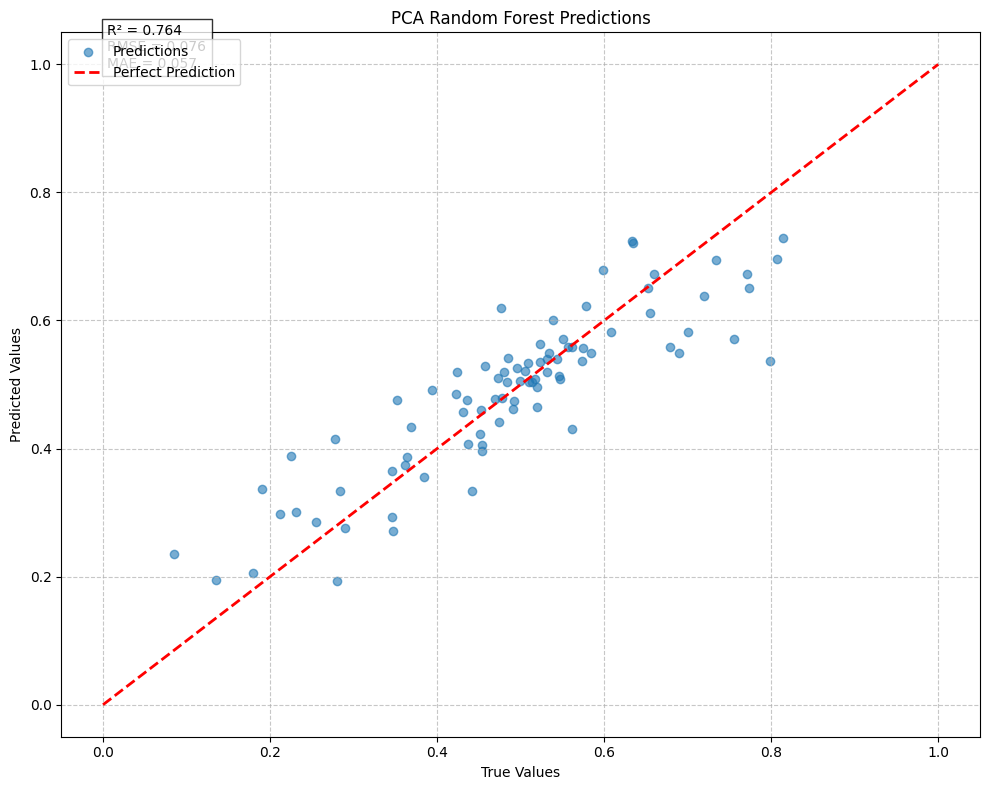

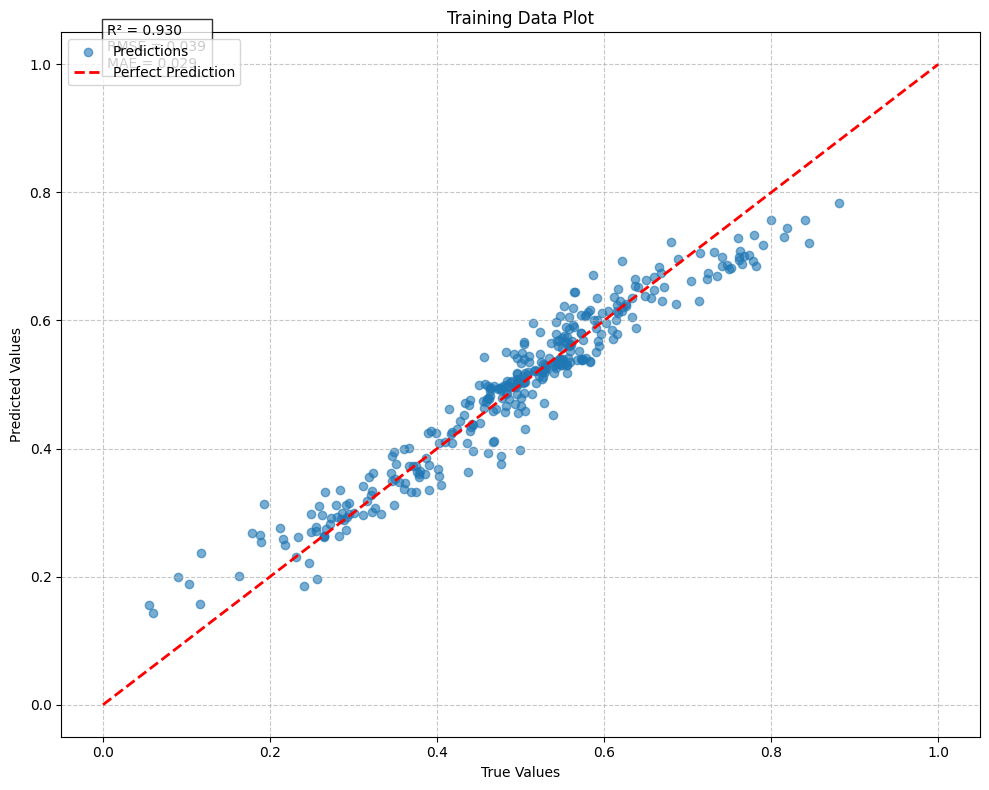

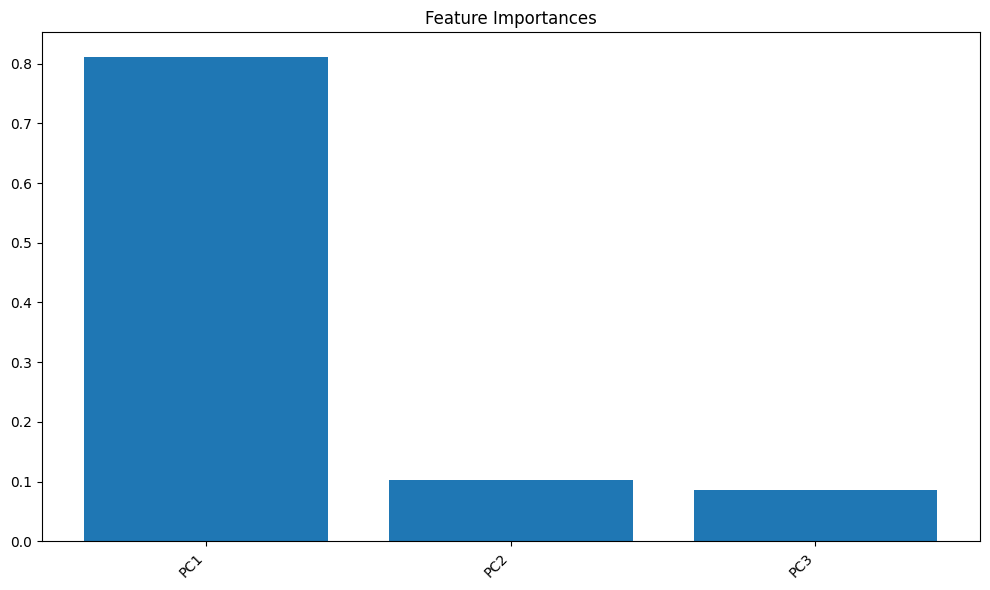


Feature Importances:
PC1: 0.8118
PC2: 0.1021
PC3: 0.0861

PCA Explained Variance Ratio:
PC1: 0.517 (51.7%)
PC2: 0.263 (26.3%)
PC3: 0.116 (11.6%)
PC4: 0.055 (5.5%)
PC5: 0.026 (2.6%)
Cumulative: 97.8%

PCA Component Loadings:
                           PC1       PC2       PC3       PC4       PC5
[M/H]_mean_mass       0.458022 -0.224895  0.537915  0.068243  0.536122
[M/H]_err_mass       -0.486706  0.177437 -0.410925  0.269837  0.596697
velDisp_ppxf_res      0.238937  0.641011  0.156135  0.663082 -0.244128
velDisp_ppxf_err_res  0.168633  0.698308  0.022407 -0.610561  0.304097
age_mean_mass         0.489614 -0.135670 -0.444075  0.273819  0.365578
age_err_mass         -0.477581  0.031673  0.565425  0.187329  0.266094

PCA Random Forest Model Evaluation:

PCA Random Forest Metrics:
R² Score: 0.8054
RMSE: 0.0686
MAE: 0.0492


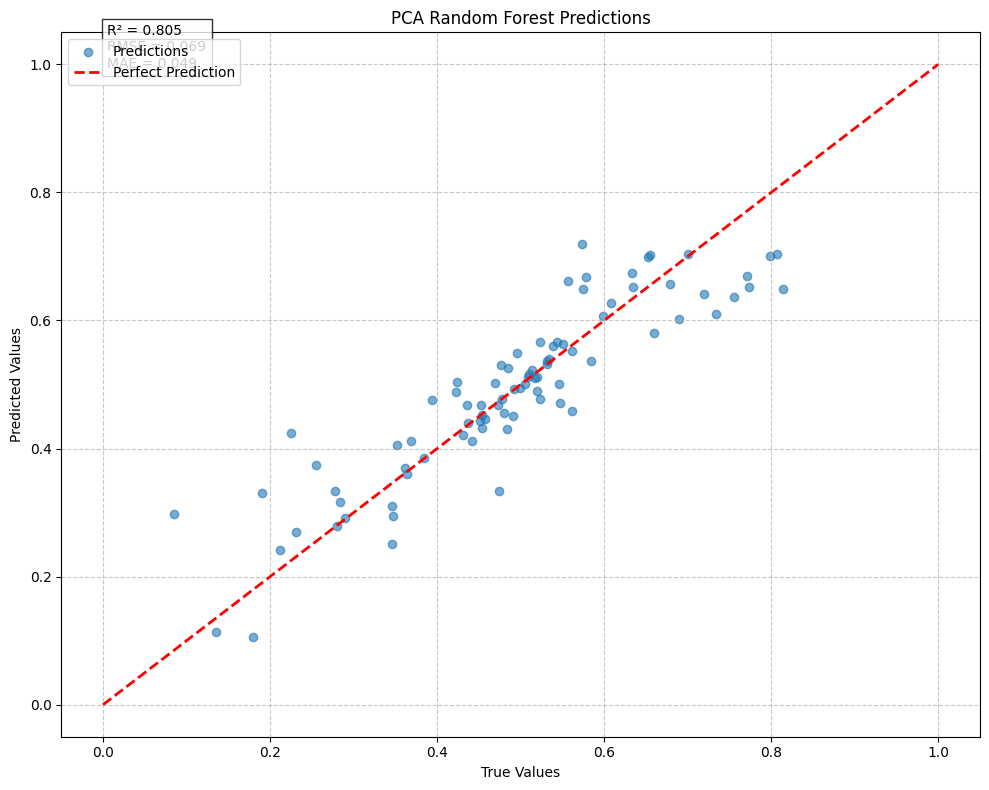

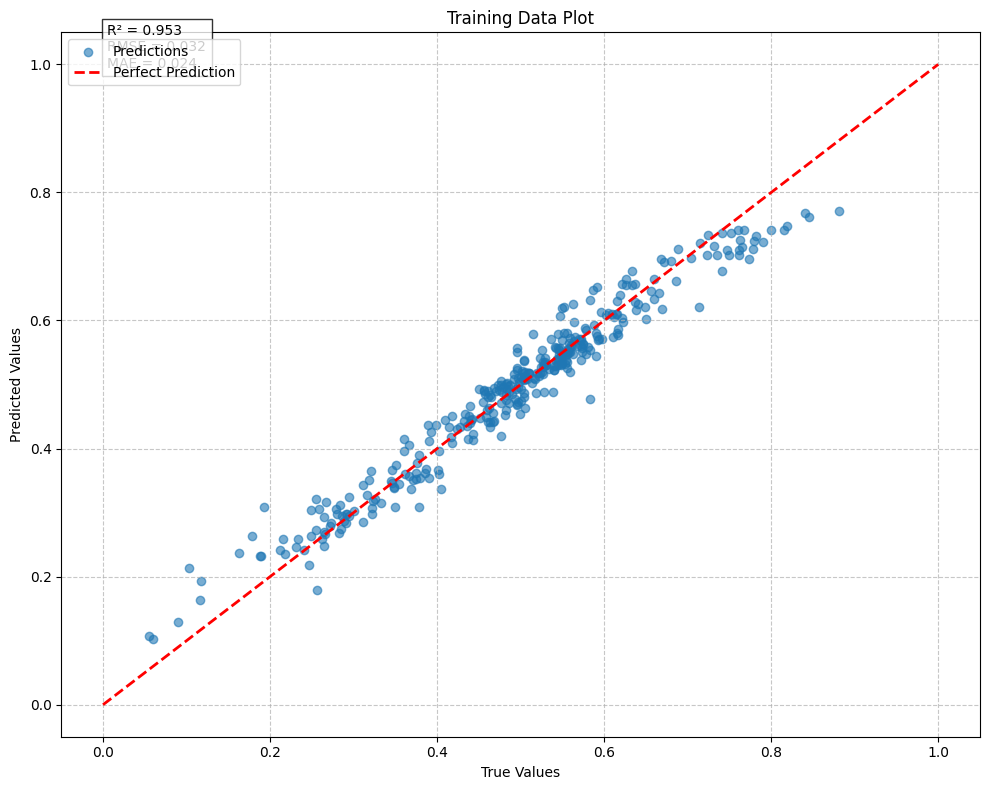

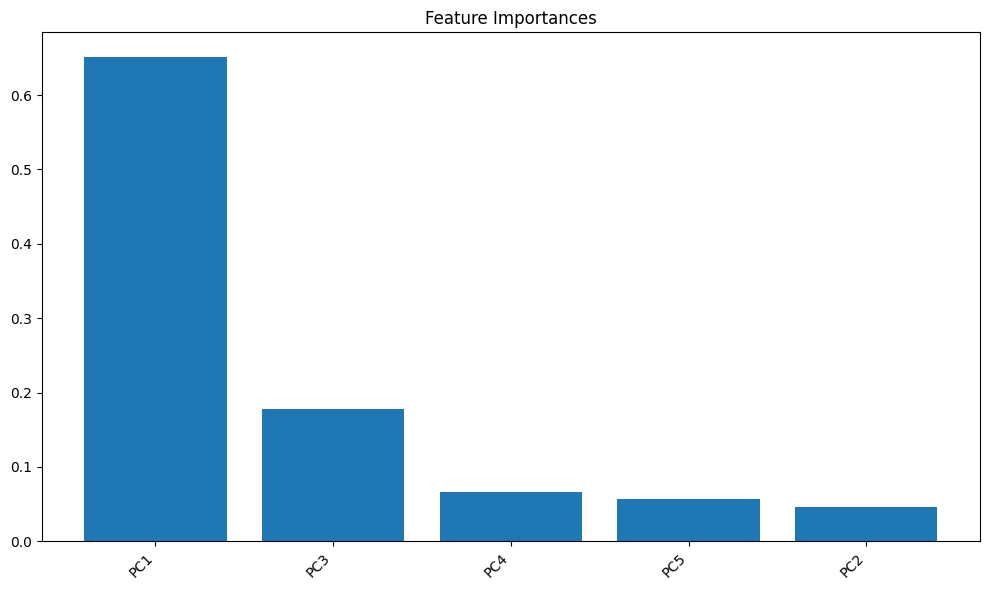


Feature Importances:
PC1: 0.6518
PC3: 0.1778
PC4: 0.0669
PC5: 0.0574
PC2: 0.0461


(RandomForestRegressor(max_depth=20, max_features=0.7, min_samples_split=5,
                       n_estimators=500, random_state=2),
 PCA(n_components=5),
 StandardScaler())

In [7]:
def run_pca_model(filepath, features, n_components):
    # Load data
    df = pd.read_csv(filepath)
    X = df[features]
    y = df['DoR']

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

    # Scale data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Print explained variance
    print("\nPCA Explained Variance Ratio:")
    for i, var in enumerate(pca.explained_variance_ratio_):
        print(f"PC{i + 1}: {var:.3f} ({var * 100:.1f}%)")
    print(f"Cumulative: {np.sum(pca.explained_variance_ratio_) * 100:.1f}%")

    # Print component loadings
    print("\nPCA Component Loadings:")
    loadings = pd.DataFrame(
        pca.components_.T,
        columns=[f'PC{i + 1}' for i in range(pca.n_components_)],
        index=features
    )
    print(loadings)

    # Train model on PCA features
    rf_pca = RandomForestRegressor(
        n_estimators=500,
        max_depth=20,
        min_samples_split=5,
        max_features=0.7,
        random_state=random_state
    )

    rf_pca.fit(X_train_pca, y_train)

    # Evaluate and plot
    print("\nPCA Random Forest Model Evaluation:")
    y_pred = evaluate_model(rf_pca, X_test_pca, y_test, "PCA Random Forest")
    plot_predictions(y_test, y_pred, title="PCA Random Forest Predictions")

    # Plot training data predictions
    plot_predictions(y_train, rf_pca.predict(X_train_pca),
                     title="Training Data Plot")

    # Plot feature importances for PCA components
    pca_features = [f'PC{i + 1}' for i in range(pca.n_components_)]
    plot_feature_importances(rf_pca, pca_features)

    return rf_pca, pca, scaler



standard_features = ['MgFe', '[M/H]_mean_mass', 'velDisp_ppxf_res', 'age_mean_mass']
run_pca_model(filepath, standard_features, n_components=3)

features_with_errors = [
    '[M/H]_mean_mass', '[M/H]_err_mass',
    'velDisp_ppxf_res', 'velDisp_ppxf_err_res',
    'age_mean_mass', 'age_err_mass'
]
run_pca_model(filepath, features_with_errors, n_components=5)

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

def evaluate_all_models(filepath, n_splits=5):
    print(f"\nRunning {n_splits}-fold cross validation on all models...")
    print("=" * 50)
    
    # Load data
    df = pd.read_csv(filepath)
    
    # Define feature sets
    standard_features = ['MgFe', '[M/H]_mean_mass', 'velDisp_ppxf_res', 'age_mean_mass']
    error_features = [
        'MgFe',
        '[M/H]_mean_mass', '[M/H]_err_mass',
        'velDisp_ppxf_res', 'velDisp_ppxf_err_res',
        'age_mean_mass', 'age_err_mass'
    ]
    
    # Initialize models
    base_rf = RandomForestRegressor(
        n_estimators=500, max_depth=20,
        min_samples_split=5, max_features=0.7,
        random_state=42
    )
    
    error_rf = RandomForestRegressor(
        n_estimators=500, max_depth=20,
        min_samples_split=5, max_features=0.7,
        random_state=42
    )
    
    weighted_rf = RandomForestRegressor(
        n_estimators=500, max_depth=20,
        min_samples_split=5, max_features=0.7,
        random_state=42
    )
    
    poly_pipeline = Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler()),
        ('rf', RandomForestRegressor(
            n_estimators=500, max_depth=20,
            min_samples_split=5, max_features=0.7,
            random_state=42
        ))
    ])
    
    nn = MLPRegressor(
        hidden_layer_sizes=(64, 32),
        activation='tanh',
        solver='lbfgs',
        alpha=0.01,
        max_iter=2000,
        random_state=42
    )
    
    ensemble = VotingRegressor([
        ('rf', base_rf),
        ('nn', nn)
    ])
    
    # Setup k-fold
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scaler = StandardScaler()
    
    # Store results for each model
    results = {
        'Base RF': {'scores': [], 'features': standard_features},
        'Error Features RF': {'scores': [], 'features': error_features},
        'Weighted RF': {'scores': [], 'features': standard_features},
        'Polynomial RF': {'scores': [], 'features': standard_features},
        'NN-RF Ensemble': {'scores': [], 'features': standard_features},
        'PCA RF': {'scores': [], 'features': standard_features}
    }
    
    # Run k-fold validation for each model
    for fold, (train_idx, test_idx) in enumerate(kf.split(df), 1):
        print(f"\nFold {fold}/{n_splits}")
        print("-" * 30)
        
        for model_name, model_info in results.items():
            # Get data for this model
            X = df[model_info['features']]
            y = df['DoR']
            
            # Split data
            X_train = X.iloc[train_idx]
            X_test = X.iloc[test_idx]
            y_train = y.iloc[train_idx]
            y_test = y.iloc[test_idx]
            
            # Scale features
            if model_name != 'Polynomial RF':  # Polynomial has its own scaler in pipeline
                X_train_scaled = scaler.fit_transform(X_train)
                X_test_scaled = scaler.transform(X_test)
            else:
                X_train_scaled = X_train
                X_test_scaled = X_test
            
            # Special handling for weighted RF
            if model_name == 'Weighted RF':
                mean_y = np.median(y_train)
                distances = np.abs(y_train - mean_y)
                weights = 1 + (distances / np.max(distances))**2 * 49  # max_weight=50
                weighted_rf.fit(X_train_scaled, y_train, sample_weight=weights)
                y_pred = weighted_rf.predict(X_test_scaled)
            
            # Special handling for PCA
            elif model_name == 'PCA RF':
                pca = PCA(n_components=3)
                X_train_pca = pca.fit_transform(X_train_scaled)
                X_test_pca = pca.transform(X_test_scaled)
                base_rf.fit(X_train_pca, y_train)
                y_pred = base_rf.predict(X_test_pca)
            
            # All other models
            else:
                if model_name == 'Base RF':
                    model = base_rf
                elif model_name == 'Error Features RF':
                    model = error_rf
                elif model_name == 'Polynomial RF':
                    model = poly_pipeline
                elif model_name == 'NN-RF Ensemble':
                    model = ensemble
                
                model.fit(X_train_scaled, y_train)
                y_pred = model.predict(X_test_scaled)
            
            # Calculate and store R² score
            r2 = r2_score(y_test, y_pred)
            results[model_name]['scores'].append(r2)
            
            print(f"{model_name} - Fold {fold} R²: {r2:.4f}")
    
    # Print final results
    print("\nFinal Results")
    print("=" * 50)
    for model_name, model_info in results.items():
        scores = model_info['scores']
        mean_r2 = np.mean(scores)
        std_r2 = np.std(scores)
        print(f"\n{model_name}:")
        print(f"Mean R²: {mean_r2:.4f} (±{std_r2:.4f})")
        print(f"Individual fold scores: {[f'{score:.4f}' for score in scores]}")
    
    return results

# Run the analysis
filepath = '../data/E-INSPIRE_I_master_catalogue.csv'
results = evaluate_all_models(filepath, n_splits=5)


Running 5-fold cross validation on all models...

Fold 1/5
------------------------------
Base RF - Fold 1 R²: 0.7927
Error Features RF - Fold 1 R²: 0.8061
Weighted RF - Fold 1 R²: 0.7946
Polynomial RF - Fold 1 R²: 0.7978
NN-RF Ensemble - Fold 1 R²: 0.7851
PCA RF - Fold 1 R²: 0.7226

Fold 2/5
------------------------------
Base RF - Fold 2 R²: 0.7674
Error Features RF - Fold 2 R²: 0.7923
Weighted RF - Fold 2 R²: 0.7665
Polynomial RF - Fold 2 R²: 0.7568
NN-RF Ensemble - Fold 2 R²: 0.7532
PCA RF - Fold 2 R²: 0.7010

Fold 3/5
------------------------------
Base RF - Fold 3 R²: 0.7770
Error Features RF - Fold 3 R²: 0.7941
Weighted RF - Fold 3 R²: 0.7755
Polynomial RF - Fold 3 R²: 0.7726
NN-RF Ensemble - Fold 3 R²: 0.7834
PCA RF - Fold 3 R²: 0.7058

Fold 4/5
------------------------------
Base RF - Fold 4 R²: 0.7946
Error Features RF - Fold 4 R²: 0.8134
Weighted RF - Fold 4 R²: 0.7759
Polynomial RF - Fold 4 R²: 0.7912
NN-RF Ensemble - Fold 4 R²: 0.7721
PCA RF - Fold 4 R²: 0.7016

Fold 5/5
